In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, matthews_corrcoef, f1_score, fbeta_score
from sklearn.impute import SimpleImputer

Potential important factors:
- ecuSource: ignore 3, 11 to see if it boosts model performance
- engine temp columns, turboBoostPressure
- BarometricPressure factors into load
- EngineLoad complicated (percentage 0-1 if not turbo-boosted)
- generally engine-related columns would be interesting

In [2]:
fault_diag = pd.read_csv('../data/fault_diag.csv')

/var/folders/xm/vmtk5pms0jzb2kmtm00lwtn80000gn/T/ipykernel_37798/699357233.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  fault_diag = pd.read_csv('../data/fault_diag.csv')


First model, simple logistic regression - not expected to do well.

In [6]:
variables = ['BarometricPressure', 'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure', 'EngineOilTemperature']

X = fault_diag[variables]
y = fault_diag['derate_full']

# split data into train/test before scaling and imputation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy = 'mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

logreg = LogisticRegression(max_iter = 1000).fit(X_train_imputed, y_train)

print(accuracy_score(y_test, logreg.predict(X_test_imputed)))
print(classification_report(y_test, logreg.predict(X_test_imputed), zero_division = 0.0))

0.9953939517420031
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    136795
        True       0.00      0.00      0.00       633

    accuracy                           1.00    137428
   macro avg       0.50      0.50      0.50    137428
weighted avg       0.99      1.00      0.99    137428



Second model. Incorporate cost information, still with simple model. *Very* bad performance on cost.

In [10]:
variables = ['BarometricPressure', 'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure', 'EngineOilTemperature']

X = fault_diag[variables]
y = fault_diag['derate_full']

# split data into train/test before scaling and imputation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy = 'mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

logreg = LogisticRegression(max_iter = 1000).fit(X_train_imputed, y_train)

# predicted probabilities for test data
y_prob = logreg.predict_proba(X_test_imputed)[:, 1]

# costs defined
cost_fn = 4000
cost_fp = 500

# decision threshord with cost as a factor
threshold = cost_fn / (cost_fn + cost_fp)

# probabilities converted to binary predictions based on new decision threshold
y_pred_adjusted = (y_prob >= threshold).astype(int)

# evaluation of adjusted predictions
print(f'Accuracy: {accuracy_score(y_test, y_pred_adjusted)}')
print(classification_report(y_test, y_pred_adjusted, zero_division = 0.0))

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)

# cost calculation
total_cost = conf_matrix[1, 0] * cost_fn + conf_matrix[0, 1] * cost_fp
print(f'Total cost: {total_cost}')

Accuracy: 0.9953939517420031
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    136795
        True       0.00      0.00      0.00       633

    accuracy                           1.00    137428
   macro avg       0.50      0.50      0.50    137428
weighted avg       0.99      1.00      0.99    137428

Total cost: 2532000


In [7]:
fault_diag.columns

Index(['RecordID', 'ESS_Id', 'EventTimeStamp', 'eventDescription', 'ecuSource',
       'spn', 'fmi', 'active', 'activeTransitionCount', 'EquipmentID',
       'Latitude', 'Longitude', 'event_date', 'event_time',
       'false_eventTimeStamp', 'event_year', 'event_month', 'event_day',
       'event_dayofweek', 'event_dayname', 'event_hour', 'event_time_quadrant',
       'derate_full', 'derate_partial', 'AcceleratorPedal',
       'BarometricPressure', 'CruiseControlActive', 'CruiseControlSetSpeed',
       'DistanceLtd', 'EngineCoolantTemperature', 'EngineLoad',
       'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm',
       'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 'FuelRate', 'IgnStatus',
       'IntakeManifoldTemperature', 'LampStatus', 'Speed',
       'TurboBoostPressure'],
      dtype='object')

Third model. Modify variables to account for information from Rob. Needs a lot more work.

In [11]:
variables = ['BarometricPressure', 'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'IntakeManifoldTemperature', 'TurboBoostPressure']

X = fault_diag[variables]
y = fault_diag['derate_full']

# split data into train/test before scaling and imputation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy = 'mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

logreg = LogisticRegression(max_iter = 1000).fit(X_train_imputed, y_train)

# predicted probabilities for test data
y_prob = logreg.predict_proba(X_test_imputed)[:, 1]

# costs defined
cost_fn = 4000
cost_fp = 500

# decision threshord with cost as a factor
threshold = cost_fn / (cost_fn + cost_fp)

# probabilities converted to binary predictions based on new decision threshold
y_pred_adjusted = (y_prob >= threshold).astype(int)

# evaluation of adjusted predictions
print(f'Accuracy: {accuracy_score(y_test, y_pred_adjusted)}')
print(classification_report(y_test, y_pred_adjusted, zero_division = 0.0))

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)

# cost calculation
total_cost = conf_matrix[1, 0] * cost_fn + conf_matrix[0, 1] * cost_fp
print(f'Total cost: {total_cost}')

Accuracy: 0.9953939517420031
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    136795
        True       0.00      0.00      0.00       633

    accuracy                           1.00    137428
   macro avg       0.50      0.50      0.50    137428
weighted avg       0.99      1.00      0.99    137428

Total cost: 2532000


Start experimenting with imbalanced class techniques.

In [26]:
variables = ['BarometricPressure', 'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'IntakeManifoldTemperature', 'TurboBoostPressure']

X = fault_diag[variables]
y = fault_diag['derate_full']

# train-test-validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 321, train_size = 0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, random_state = 321, train_size = 0.6/0.8)

# same model as before
# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy = 'mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_val_imputed = imputer.transform(X_val)

logreg = LogisticRegression(max_iter = 1000).fit(X_train_imputed, y_train)

# predicted probabilities for test data
y_prob = logreg.predict_proba(X_val_imputed)[:, 1]

# costs defined
cost_fn = 4000
cost_fp = 500

# decision threshold with cost as a factor
threshold = cost_fn / (cost_fn + cost_fp)

# probabilities converted to binary predictions based on new decision threshold
y_pred_adjusted = (y_prob >= threshold).astype(int)

# evaluation of adjusted predictions
print(f'Accuracy: {accuracy_score(y_test, y_pred_adjusted)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_adjusted)}')
print(classification_report(y_test, y_pred_adjusted, zero_division = 0.0))

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
print(f'Confusion matrix: {conf_matrix}')

# cost calculation
total_cost = conf_matrix[1, 0] * cost_fn + conf_matrix[0, 1] * cost_fp
print(f'Total cost: {total_cost}')

Accuracy: 0.9953884775608958
MCC: 0.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    109435
        True       0.00      0.00      0.00       507

    accuracy                           1.00    109942
   macro avg       0.50      0.50      0.50    109942
weighted avg       0.99      1.00      0.99    109942

Confusion matrix: [[109435      0]
 [   507      0]]
Total cost: 2028000


In [22]:
# changing decision threshold
y_val_pred_proba = logreg.predict_proba(X_val_imputed)[:,1]

candidate_thresholds = np.arange(start = 0.1, stop = 0.925, step = 0.01)
thresholds = pd.DataFrame({'threshold': candidate_thresholds})
thresholds['f1'] = thresholds['threshold'].apply(lambda x: f1_score(y_val, y_val_pred_proba > x))
thresholds.sort_values('f1', ascending = False).head()

,threshold,f1
0,0.10,0.0
62,0.72,0.0
60,0.70,0.0
59,0.69,0.0
58,0.68,0.0


In [24]:
# trying F-beta
beta = 0.10

thresholds = pd.DataFrame({'threshold': candidate_thresholds})
thresholds['fbeta'] = thresholds['threshold'].apply(lambda x: fbeta_score(y_val, y_val_pred_proba > x, beta = beta))
thresholds.sort_values('fbeta', ascending = False).head()

,threshold,fbeta
0,0.10,0.0
62,0.72,0.0
60,0.70,0.0
59,0.69,0.0
58,0.68,0.0


In [55]:
# whatever value I tried with beta, it had the same thresholds in the same order with 0 for the value (same with decision threshold)
# trying one anyway
threshold = 0.001

y_pred_proba = logreg.predict_proba(X_test_imputed)[:,1]

y_pred = y_pred_proba > threshold
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.005703007040075677
MCC: -0.013423540024759923
[[   124 109311]
 [     4    503]]
              precision    recall  f1-score   support

       False       0.97      0.00      0.00    109435
        True       0.00      0.99      0.01       507

    accuracy                           0.01    109942
   macro avg       0.49      0.50      0.01    109942
weighted avg       0.96      0.01      0.00    109942



In [56]:
# going to an extremely low threshold at least shifted the needle, putting that through cost calculations
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# cost calculation
total_cost = conf_matrix[1, 0] * cost_fn + conf_matrix[0, 1] * cost_fp
print(f'Total cost: {total_cost}')

### MUCH WORSE ###
# changing the beta value produced worse results from a cost perspective at any value where it predicted any derates at all - too many false positives?

Total cost: 54671500


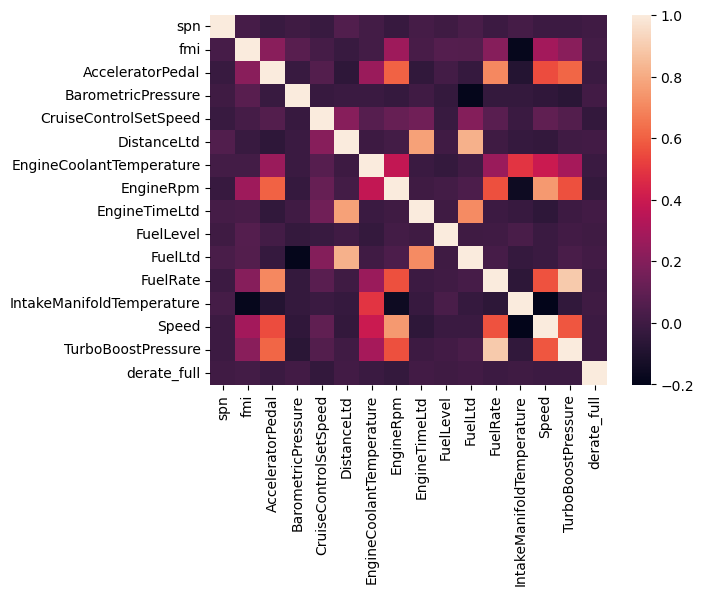

In [93]:
# see which predictors are correlated and take out half of highly correlated pairs
corr_columns = ['spn', 'fmi', 'AcceleratorPedal', 'BarometricPressure', 'CruiseControlSetSpeed', 'DistanceLtd', 'EngineCoolantTemperature', 'EngineRpm', 
                'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 'FuelRate', 'IntakeManifoldTemperature', 'Speed', 'TurboBoostPressure', 'derate_full']

corr_matrix = fault_diag[corr_columns].corr()
# print(corr_matrix)

sns.heatmap(corr_matrix);


In [94]:
# code to find more correlated columns
# from https://medium.com/@yatharthranjan/finding-top-correlation-pairs-from-a-large-number-of-variables-in-pandas-f530be53e82a#:~:text=The%20Pandas%20DataFrame%20function%20corr,is%20massive%20on%20both%20axes.
# modified slightly for use with this dataset

def get_top_correlations_blog(df, columns, threshold=0.6):
    """
    df: the dataframe to get correlations from
    threshold: the maximum and minimum value to include for correlations. For eg, if this is 0.4, only pairs haveing a correlation coefficient greater than 0.4 or less than -0.4 will be included in the results. 
    """
    
    orig_corr = df[columns].corr()
    c = orig_corr.abs()

    so = c.unstack()

    print("|    Variable 1    |    Variable 2    | Correlation Coefficient    |")
    print("|------------------|------------------|----------------------------|")
    
    i=0
    pairs=set()
    result = pd.DataFrame()
    for index, value in so.sort_values(ascending = False).items():
        # Exclude duplicates and self-correlations
        if value > threshold \
        and index[0] != index[1] \
        and (index[0], index[1]) not in pairs \
        and (index[1], index[0]) not in pairs:
            
            print(f'|    {index[0]}    |    {index[1]}    |    {orig_corr.loc[(index[0], index[1])]}    |')
            result.loc[i, ['Variable 1', 'Variable 2', 'Correlation Coefficient']] = [index[0], index[1], orig_corr.loc[(index[0], index[1])]]
            pairs.add((index[0], index[1]))
            i+=1
    return result.reset_index(drop=True).set_index(['Variable 1', 'Variable 2'])


In [95]:
get_top_correlations_blog(fault_diag, corr_columns, 0.6)

|    Variable 1    |    Variable 2    | Correlation Coefficient    |
|------------------|------------------|----------------------------|
|    FuelRate    |    TurboBoostPressure    |    0.8967936356237725    |
|    DistanceLtd    |    FuelLtd    |    0.8183936008017506    |
|    DistanceLtd    |    EngineTimeLtd    |    0.770309846146007    |
|    Speed    |    EngineRpm    |    0.7487714133549392    |
|    FuelLtd    |    EngineTimeLtd    |    0.710117814514225    |
|    FuelRate    |    AcceleratorPedal    |    0.6999800206111046    |
|    TurboBoostPressure    |    AcceleratorPedal    |    0.6112815918077457    |
|    EngineRpm    |    AcceleratorPedal    |    0.6056980009931799    |


Correlation Coefficient
Variable 1         Variable 2                                 
FuelRate           TurboBoostPressure                 0.896794
DistanceLtd        FuelLtd                            0.818394
                   EngineTimeLtd                      0.770310
Speed              EngineRpm                          0.748771
FuelLtd            EngineTimeLtd                      0.710118
FuelRate           AcceleratorPedal                   0.699980
TurboBoostPressure AcceleratorPedal                   0.611282
EngineRpm          AcceleratorPedal                   0.605698

In [92]:
# take AcceleratorPedal, FuelLtd, DistanceLtd, FuelRate, Speed out of model and try it with cost threshold
variables = ['BarometricPressure', 'CruiseControlSetSpeed', 'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 
             'FuelLevel', 'IntakeManifoldTemperature', 'TurboBoostPressure']

X = fault_diag[variables]
y = fault_diag['derate_full']

# train-test-validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 321, train_size = 0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, random_state = 321, train_size = 0.6/0.8)

# same model as before
# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy = 'mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_val_imputed = imputer.transform(X_val)

logreg = LogisticRegression(max_iter = 1000).fit(X_train_imputed, y_train)

# predicted probabilities for test data
y_prob = logreg.predict_proba(X_val_imputed)[:, 1]

# costs defined
cost_fn = 4000
cost_fp = 500

# decision threshold with cost as a factor
# threshold = cost_fn / (cost_fn + cost_fp)
threshold = 0.005

# probabilities converted to binary predictions based on new decision threshold
y_pred_adjusted = (y_prob >= threshold).astype(int)

# evaluation of adjusted predictions
print(f'Accuracy: {accuracy_score(y_test, y_pred_adjusted)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_adjusted)}')
print(classification_report(y_test, y_pred_adjusted, zero_division = 0.0))

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
print(f'Confusion matrix: {conf_matrix}')

# cost calculation
total_cost = conf_matrix[1, 1] * cost_fn * -1 + conf_matrix[0, 1] * cost_fp # 2nd column
print(f'Total cost: {total_cost}')

Accuracy: 0.7680686179985811
MCC: 0.0005301570253521355
              precision    recall  f1-score   support

       False       1.00      0.77      0.87    109435
        True       0.00      0.23      0.01       507

    accuracy                           0.77    109942
   macro avg       0.50      0.50      0.44    109942
weighted avg       0.99      0.77      0.86    109942

Confusion matrix: [[84325 25110]
 [  389   118]]
Total cost: 12083000


In [88]:
X_train.shape

(329825, 11)

Really just need to do better with the basic model I think. Haven't found anything that improves it. Try scaling the variables as well as imputing nulls.
Also try other types of models. I just read that Random forests and gradient boosting don't require scaling.

In [98]:
# not actually fitting a classifier? investigate that issue
variables = ['BarometricPressure', 'CruiseControlSetSpeed', 'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel', 
             'IntakeManifoldTemperature', 'TurboBoostPressure']

X = fault_diag[variables]
y = fault_diag['derate_full']

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy = 'mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_val_imputed = imputer.transform(X_val)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

# Ridge Regression model
ridge = Ridge(alpha = 1.0)  # You can adjust the alpha parameter for regularization strength
ridge.fit(X_train_scaled, y_train)

# Make predictions
y_pred = ridge.predict(X_val_scaled)

# costs defined
cost_fn = 4000
cost_fp = 500

# decision threshold with cost as a factor
# threshold = cost_fn / (cost_fn + cost_fp)
threshold = 0.015

# Convert probabilities to binary predictions based on a threshold
y_pred_adjusted = (y_pred >= threshold).astype(int)

# Evaluation of adjusted predictions
print(f'Accuracy: {accuracy_score(y_test, y_pred_adjusted)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_adjusted)}')
print(classification_report(y_test, y_pred_adjusted, zero_division = 0.0))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
print(f'Confusion matrix: {conf_matrix}')

# Cost calculation
total_cost = conf_matrix[1, 1] * cost_fn * -1 + conf_matrix[0, 1] * cost_fp
print(f'Total cost: {total_cost}')

Accuracy: 0.974959524112714
MCC: -0.0013617240709099738
              precision    recall  f1-score   support

       False       1.00      0.98      0.99    109435
        True       0.00      0.02      0.01       507

    accuracy                           0.97    109942
   macro avg       0.50      0.50      0.50    109942
weighted avg       0.99      0.97      0.98    109942

Confusion matrix: [[107180   2255]
 [   498      9]]
Total cost: 1091500


In [ ]:
# hist gradient boosting classifier - faster than random forrest